In [1]:
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader
from bs4 import BeautifulSoup as Soup
from urllib.parse import urlparse, urljoin
import re

##dbs星展, sinopac永豐
bank_urls = {
            'dbs':'https://www.dbs.com.tw/personal-zh/cards/dbs-credit-cards/default.page', 
            'sinopac':'https://bank.sinopac.com/sinopacBT/personal/credit-card/introduction/list.html',
            'cathy': 'https://www.cathaybk.com.tw/cathaybk/personal/product/credit-card/cards/',
            'firstbank': 'https://card.firstbank.com.tw/sites/card/CreditCardList'
             }

In [2]:

credit_card_urls = {}
soup_documents = {k:None for k in list(bank_urls.keys())}

for bank, url in bank_urls.items():
    loader = RecursiveUrlLoader(url=url)
    docs = loader.load()
    if bank == 'dbs':
        links = list(set([a['href'] for a in Soup(docs[0].page_content).find_all('a', href=True) if (a['href'].startswith('/personal-zh/cards')) and (a['href'].endswith('hyperlink'))]))
        credit_card_urls[bank] = [urljoin(url, i) for i in links]
    elif bank == 'sinopac':
        links = list(set([a['href'] for a in Soup(docs[0].page_content).find_all('a', href=True) if a['href'].startswith('./')]))
        credit_card_urls[bank] = [urljoin(url, i) for i in links]
    elif bank == 'firstbank':
        def firstbank_extractor(html:str):
            soup_obj = Soup(html, 'html.parser')
            credit_card_feature = [re.sub(r'\n+', '\n', d.text) for d in soup_obj.find_all('div', {"class":[["card-single-features"]]})]
            txt = ''
            for features in  credit_card_feature:
                split = features.split('\n', 1)
                txt += f"信用卡卡名：{split[0].strip()}\n信用卡特色: {split[1]}"
            return txt
        all_html = RecursiveUrlLoader(bank_urls['firstbank'], extractor=firstbank_extractor).load()
        all_html[0].metadata['bank'] = 'firstbank'
        soup_documents[bank] = all_html

        divs = [Soup(doc.page_content, 'html.parser').find_all('div', {"class":'card-single'}) for doc in docs][0]
        links = []
        for d in divs:
            link_tags = d.find_all('a')
            if len(link_tags) == 1:
                detail_url = link_tags[0]['href']
                links.append(detail_url)
            else:
                for tag in link_tags:
                    if tag.text == '詳細內容':
                        links.append(tag['href'])
                    else:
                        continue
        credit_card_urls[bank] = [urljoin(url, i) for i in links]
    elif bank == 'cathy':
        def parser(html):
            ## main page
            divs = Soup(html, 'html.parser').find_all('div', {'class':'cubre-m-compareCard -credit'})
            if divs:
                divs = [re.sub(r'\n+', '\n', i.text) for i in divs]
                txt = (' ').join(divs)
                txt = re.sub(r' +', ' ', txt)
                txt = [t.replace('\n立即申辦','', 1) for t in txt.split('詳細說明') if t.startswith('\n立即申辦')]
                txt = ('').join(txt).replace('\n \n', '\n')
            else:
                ## deeper page
                divs = Soup(html, 'html.parser').find_all('div', class_=["cubre-o-textContent", "cubre-m-colorBanner__title","cubre-m-iconEssay__title","cubre-m-horGraphic__title","cubre-m-remind__title","cubre-m-puzzle__title","cubre-a-kvTitle -card"])
                divs = [d.text for d in divs if '您將離開本行官網 前往外部網站' not in d.text]
                uni_divs = []
                for d in divs[:len(divs)-1]:
                    if d not in uni_divs:
                        uni_divs.append(d)
                txt = re.sub(r'\n+', '\n', ('\n').join(uni_divs))
                txt = re.sub(r' +', ' ', txt)
            return txt
            
        docs = RecursiveUrlLoader(url=url, extractor=parser).load()
        for d in docs:
            d.metadata['bank'] = '國泰銀行'
            d.metadata['credit card'] = d.metadata['title'].split('-', 1)[0].strip()
            d.metadata['electronic payment']  = ''
        docs = [d for d in docs if '停發' not in d.metadata['title']]
        soup_documents['cathy'] = docs
        

In [10]:
from langchain_community.document_loaders.url_selenium import SeleniumURLLoader
# documents = {}
# for bank, links in credit_card_urls.items():
#     documents[bank] = SeleniumURLLoader(urls=links).load()
        

In [3]:
def sinopac_extractor(html: str) -> str:
    soup = Soup(html, "html.parser")
    divs_txt = [s.text for s in soup.find_all('div', {'class':'tab-box'})]
    divs_txt.insert(0, re.sub(r'\n\n+', '\n', soup.find('div', {'class':'info'}).text))
    div_set = []
    for txt in divs_txt:
        if txt not in div_set:
            div_set.append(txt)
    txt = re.sub(r'[\t\r\xa0]', '', ('\n').join(div_set))
    txt = re.sub(r'  +', ' ', txt)
    txt = re.sub(r'\n+', '\n', txt)
    return txt.strip()

def dbs_extractor(html:str)->str:
    soup = Soup(html, "html.parser")
    divs_txt = [s.text for s in soup.find_all('div', {'class':'flpweb-legacy'})]
    if divs_txt:
        div_set = []
        for txt in divs_txt:
            if txt not in div_set:
                div_set.append(txt)
        all_txt = ('\n').join(div_set)
    else:
        txt = soup.text
        txt = [t.strip() for t in txt.split('\n') if( t != 'more..') and (len(txt.strip()) != 1)]
        all_txt = ('\n').join(txt)

    all_txt = all_txt.replace('個人網路銀行\nCard+ 信用卡數位服務\n企業網路銀行', '')
    all_txt = re.sub(r'[\t\r\xa0]', '', all_txt)
    all_txt = re.sub(r'\xa0', '', all_txt)
    all_txt = re.sub(r'  +', ' ', all_txt)
    all_txt = re.sub(r'\n+', '\n', all_txt)
    all_txt = all_txt.split('信用卡刷卡優惠更多星展信用卡刷卡優惠信息，詳情請見刷卡優惠說明。')[0]

    if '假字假字假字假字假字假字假字假字假字假字' in all_txt:
        all_txt = re.sub('假字假字假字+', '', all_txt)

    pattern = r"網銀登入\n[\s\S]*?選擇您的網站 ▼\n個人金融\n個人金融\n財富管理\n星展豐盛理財\n星展豐盛私人客戶\n企業金融\n中小企業銀行\n企業及機構銀行\n星展集團\n關於我們"
    # Replace the matched portion with an empty string
    all_txt = re.sub(pattern, '', all_txt)
    pattern = r'Loading...\n尊享至上\n[\s\S]*?\n權益手冊\n更多獨享優惠'
    all_txt = re.sub(pattern, '', all_txt)
    pattern = r'新戶好禮\n[\s\S]*?\n更多星展信用卡'
    all_txt = re.sub(pattern, '', all_txt)
    all_txt = all_txt.split('謹慎理財 信用至上')[0]
    return all_txt.strip()

def firstbank_extractor(html:str)->str:
    divs = Soup(html, 'html.parser').find_all('div', {"class":['carousel-item', 'content-body']})
    return ('').join([re.sub(r'\n+', '\n', d.text) for d in divs])

for bank, links in credit_card_urls.items():
    docs = []
    if bank == 'sinopac':
        for url in links:
            doc = RecursiveUrlLoader(url=url, extractor=sinopac_extractor).load()
            doc[0].metadata['bank'] = '永豐銀行'
            docs.extend(doc)
    elif bank == 'dbs':
        for url in links:
            doc = RecursiveUrlLoader(url=url, extractor=dbs_extractor).load()
            if doc:
                doc[0].metadata['bank'] = '星展銀行'
                docs.extend(doc)
    elif bank == 'firstbank':
        for url in links:
            doc = RecursiveUrlLoader(url=url, extractor=firstbank_extractor).load()
            doc[0].metadata['bank'] = '第一銀行'
            docs.extend(doc)
    if soup_documents[bank]:
        soup_documents[bank].extend(docs)
    else:
        soup_documents[bank] = docs

In [4]:
for k,v in soup_documents.items():
    print(f"Bank {k}: {len(v)}")

Bank dbs: 23
Bank sinopac: 45
Bank cathy: 18
Bank firstbank: 37


## Extract credit card name from DBS, Sinopac

In [5]:
from langchain_core.prompts import PromptTemplate
from langchain.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
import string
import re

chinese_punctuation = "。！；：，、【】《》『』——"
translator = str.maketrans('', '', chinese_punctuation)

for k in list(soup_documents.keys()):
    if (k == 'sinopac'):
        for index, doc in enumerate(soup_documents[k]):
            credit_card = doc.page_content.split('\n')[0]
            # print(credit_card)
            if credit_card.endswith('卡'):
                soup_documents[k][index].metadata['credit card'] = credit_card
                soup_documents[k][index].metadata['electronic payment']  = ''
            elif 'pay' in credit_card.lower():
                soup_documents[k][index].metadata['credit card'] = ''
                soup_documents[k][index].metadata['electronic payment']  = credit_card
                
    elif k == 'dbs':
        for index, doc in enumerate(soup_documents[k]):
            credit_card = doc.page_content.split('\n')[0].split('|')[0].translate(translator)
            match = re.search(r'星展.*?卡', credit_card)
            if match:
                soup_documents[k][index].metadata['credit card'] = match.group()  # Output: 星展HAPPY GO聯名卡
                soup_documents[k][index].metadata['electronic payment']  = ''
            else:
                match = re.search(r'星展.*?卡', doc.metadata['description'])
                if match:
                    soup_documents[k][index].metadata['credit card'] = match.group()
                    soup_documents[k][index].metadata['electronic payment']  = ''
                else:
                    soup_documents[k][index].metadata['credit card'] = ''
                    pass
    elif k == 'firstbank':
        for index, doc in enumerate(soup_documents[k]):
            credit_card = doc.metadata['title'].strip()
            match = re.search(r'^(.*?)\s*-\s*信用卡', credit_card)
            if match:
                credit_card = match.group(1).split('_')[0]
                if credit_card.endswith('卡'):
                    soup_documents[k][index].metadata['credit card']  = credit_card
                    soup_documents[k][index].metadata['electronic payment']  = ''
                elif 'pay' in credit_card.lower():
                    soup_documents[k][index].metadata['credit card']  = ''
                    soup_documents[k][index].metadata['electronic payment']  = credit_card
                else:
                    soup_documents[k][index].metadata['credit card']  = ''
            else:
                pass

In [7]:
import json 
from langchain_core.documents import Document
import re
with open('documents.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

documents = []
txt_documents = []
for key in list(data.keys()):
    for d in data[key]:
        doc = Document(metadata={k:v for k,v in d.items() if k != 'page_content'}, page_content=re.sub(r'\t+', '\t', d['page_content']))
        txt_documents.append(re.sub(r'\t+', '\t', d['page_content']))
        documents.append(doc)
# documents

In [8]:
documents[0].page_content

'星展eco永續極簡卡\n國內／國外一般消費回饋1.2%無上限日本／韓國／泰國／新加坡 / 美洲地區 享最優5%回饋\n一般消費回饋1.2%權益適用期間：2025/01/01~2025/06/30國內／國外一般消費，筆筆回饋1.2%國外指定地區最高回饋5%權益適用期間：2025/01/01~2025/06/30日本／韓國／泰國／新加坡/ 美洲地區 享加碼最高5%（含原 1.2% 及加碼 3.8% 每期帳單上限 800 點）eco消費，最高享10%回饋權益適用期間：2025/01/01~2025/06/30星展支持的社會企業及中小企業／Tesla充電資費／Gogoro 電池資費享最高10%回饋（含原 1.2% +加碼 8.8% 每期帳單上限 300 點）\n 星展eco永續極簡卡現金紅利回饋活動注意事項星展eco永續極簡卡國內及國外一般消費 1.2% 現金紅利回饋活動注意事項：活動期間：2025／01／01 ~ 2025／06／30。正附卡持卡人刷卡消費之入帳日須介於活動期間內，同時符合本注意事項之一般消費定義，方適用本活動回饋辦法，稱為合格消費。本活動辦法同時適用於國外指定地區一般消費加碼及eco消費加碼，若無特殊標明則皆以現金紅利（下稱點數）回饋。現金紅利於每期帳單結帳回饋後，持卡期間有效。合格消費計算點數回饋之週期係以台灣時間本行系統入帳日為準，若商家未及於帳單結帳前請款，導致入帳日不在當期帳單結帳週期，則該筆交易視為次期帳單交易。回饋計算方式為每期帳單所列示之合格消費，當期帳單新增消費金額需大於退款金額，方可開始獲得點數。將國內外消費金額加總後乘上適用回饋比率後於小數點以下四捨五入至整數位，國內外退款金額加總後乘上適用回饋比率後於小數點以下四捨五入至整數位，兩者合計即為當期獲得或扣除之點數回饋，正附卡可得之消費回饋將合併計入正卡帳戶回饋。當期帳單結帳後可得之回饋顯示於帳單回饋獎勵計畫明細及說明，當期點數往來之歷史紀錄及餘額皆須以持卡人信用卡對帳單為主。當期回饋無論獲得或扣除皆列示於新增欄位，點數兌換則列示於調整欄位，當期帳單點數餘額則無論正負數皆列示於結餘欄位。正卡帳單上所載之負項刷卡消費包含但不限於：取消交易、退款、於國外以本卡消費並以本卡退稅、於國外未以本卡消費但以本卡退稅、簽帳爭議款及其他原因而產生負向刷卡消費之情事。本行將於當期或次期帳單依負向金額加總

In [13]:
txt_documents[:23]

['星展eco永續極簡卡\n國內／國外一般消費回饋1.2%無上限日本／韓國／泰國／新加坡 / 美洲地區 享最優5%回饋\n一般消費回饋1.2%權益適用期間：2025/01/01~2025/06/30國內／國外一般消費，筆筆回饋1.2%國外指定地區最高回饋5%權益適用期間：2025/01/01~2025/06/30日本／韓國／泰國／新加坡/ 美洲地區 享加碼最高5%（含原 1.2% 及加碼 3.8% 每期帳單上限 800 點）eco消費，最高享10%回饋權益適用期間：2025/01/01~2025/06/30星展支持的社會企業及中小企業／Tesla充電資費／Gogoro 電池資費享最高10%回饋（含原 1.2% +加碼 8.8% 每期帳單上限 300 點）\n 星展eco永續極簡卡現金紅利回饋活動注意事項星展eco永續極簡卡國內及國外一般消費 1.2% 現金紅利回饋活動注意事項：活動期間：2025／01／01 ~ 2025／06／30。正附卡持卡人刷卡消費之入帳日須介於活動期間內，同時符合本注意事項之一般消費定義，方適用本活動回饋辦法，稱為合格消費。本活動辦法同時適用於國外指定地區一般消費加碼及eco消費加碼，若無特殊標明則皆以現金紅利（下稱點數）回饋。現金紅利於每期帳單結帳回饋後，持卡期間有效。合格消費計算點數回饋之週期係以台灣時間本行系統入帳日為準，若商家未及於帳單結帳前請款，導致入帳日不在當期帳單結帳週期，則該筆交易視為次期帳單交易。回饋計算方式為每期帳單所列示之合格消費，當期帳單新增消費金額需大於退款金額，方可開始獲得點數。將國內外消費金額加總後乘上適用回饋比率後於小數點以下四捨五入至整數位，國內外退款金額加總後乘上適用回饋比率後於小數點以下四捨五入至整數位，兩者合計即為當期獲得或扣除之點數回饋，正附卡可得之消費回饋將合併計入正卡帳戶回饋。當期帳單結帳後可得之回饋顯示於帳單回饋獎勵計畫明細及說明，當期點數往來之歷史紀錄及餘額皆須以持卡人信用卡對帳單為主。當期回饋無論獲得或扣除皆列示於新增欄位，點數兌換則列示於調整欄位，當期帳單點數餘額則無論正負數皆列示於結餘欄位。正卡帳單上所載之負項刷卡消費包含但不限於：取消交易、退款、於國外以本卡消費並以本卡退稅、於國外未以本卡消費但以本卡退稅、簽帳爭議款及其他原因而產生負向刷卡消費之情事。本行將於當期或次期帳單依負向金額加

In [11]:
from ragatouille import RAGPretrainedModel

RAG = RAGPretrainedModel.from_pretrained("jinaai/jina-colbert-v2")
# docs = [
#     "ColBERT is a novel ranking model that adapts deep LMs for efficient retrieval.",
#     "Jina-ColBERT is a ColBERT-style model but based on JinaBERT so it can support both 8k context length, fast and accurate retrieval.",
# ]
RAG.index(txt_documents[:23], index_name="demo")
query = "星展PChome Prime聯名卡什麼通路有優惠？"
results = RAG.search(query)


---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Feb 17, 15:18:09] #> Note: Output directory .ragatouille/colbert/indexes/demo already exists


[Feb 17, 15:18:15] [0] 		 #> Encoding 3495 passages..


100%|██████████| 10/10 [00:31<00:00,  3.11s/it]

[Feb 17, 15:25:44] [0] 		 avg_doclen_est = 110.19026947021484 	 len(local_sample) = 3,495
[Feb 17, 15:25:44] [0] 		 Creating 8,192 partitions.
[Feb 17, 15:25:44] [0] 		 *Estimated* 385,114 embeddings.
[Feb 17, 15:25:44] [0] 		 #> Saving the indexing plan to .ragatouille/colbert/indexes/demo/plan.json ..



/Users/sarah/Desktop/AI/llm_env/lib/python3.11/site-packages/colbert/indexing/collection_indexer.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sub_sample = torch.lo

used 20 iterations (210.4749s) to cluster 365860 items into 8192 clusters
[0.022, 0.022, 0.024, 0.022, 0.023, 0.021, 0.023, 0.021, 0.021, 0.021, 0.024, 0.021, 0.021, 0.022, 0.021, 0.025, 0.023, 0.021, 0.024, 0.023, 0.022, 0.024, 0.022, 0.023, 0.02, 0.022, 0.023, 0.022, 0.021, 0.022, 0.022, 0.024, 0.021, 0.02, 0.023, 0.022, 0.021, 0.023, 0.021, 0.022, 0.02, 0.022, 0.023, 0.021, 0.022, 0.023, 0.023, 0.023, 0.022, 0.021, 0.021, 0.022, 0.023, 0.021, 0.021, 0.022, 0.021, 0.022, 0.021, 0.022, 0.021, 0.022, 0.022, 0.022, 0.022, 0.023, 0.021, 0.023, 0.021, 0.02, 0.021, 0.022, 0.021, 0.023, 0.021, 0.021, 0.023, 0.02, 0.022, 0.022, 0.023, 0.023, 0.022, 0.021, 0.023, 0.022, 0.023, 0.022, 0.022, 0.021, 0.022, 0.021, 0.022, 0.02, 0.021, 0.024, 0.021, 0.022, 0.023, 0.022, 0.019, 0.024, 0.022, 0.024, 0.021, 0.023, 0.022, 0.024, 0.022, 0.022, 0.022, 0.022, 0.022, 0.022, 0.023, 0.022, 0.023, 0.022, 0.023, 0.022, 0.023, 0.023, 0.022, 0.021, 0.021, 0.021, 0.02, 0.021]


/Users/sarah/Desktop/AI/llm_env/lib/python3.11/site-packages/colbert/indexing/codecs/residual.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  centroids = torch.load(ce

[Feb 17, 15:29:15] [0] 		 #> Encoding 3495 passages..





















































100%|██████████| 50/50 [03:24<00:00,  4.10s/it]



















































100%|██████████| 50/50 [03:35<00:00,  4.31s/it]











100%|██████████| 10/10 [00:31<00:00,  3.10s/it]
1it [07:36, 456.99s/it]
/Users/sarah/Desktop/AI/llm_env/lib/python3.11/site-packages/colbert/indexing/codecs/residual_embeddings.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowliste

[Feb 17, 15:36:52] #> Optimizing IVF to store map from centroids to list of pids..
[Feb 17, 15:36:52] #> Building the emb2pid mapping..
[Feb 17, 15:36:52] len(emb2pid) = 385115



100%|██████████| 8192/8192 [00:00<00:00, 42245.96it/s]


[Feb 17, 15:36:52] #> Saved optimized IVF to .ragatouille/colbert/indexes/demo/ivf.pid.pt
Done indexing!
Loading searcher for index demo for the first time... This may take a few seconds
[Feb 17, 15:37:02] #> Loading codec...
[Feb 17, 15:37:02] #> Loading IVF...
[Feb 17, 15:37:02] Loading segmented_lookup_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/Users/sarah/Desktop/AI/llm_env/lib/python3.11/site-packages/colbert/search/index_loader.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ivf, ivf_lengths = torch.load(o

[Feb 17, 15:37:09] #> Loading doclens...


100%|██████████| 1/1 [00:00<00:00, 1644.83it/s]

[Feb 17, 15:37:09] #> Loading codes and residuals...



/Users/sarah/Desktop/AI/llm_env/lib/python3.11/site-packages/colbert/indexing/codecs/residual_embeddings.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.l

[Feb 17, 15:37:09] Loading filter_pids_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


[Feb 17, 15:37:15] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: 星展PChome Prime聯名卡什麼通路有優惠？, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([     0, 250002,      6,   7367,   8869,  12233,  29552,  56195,  16414,
          1795,   4624,  17194, 185661,    465,  21782,     32,      2, 250001,
        250001, 250001, 250001, 250001, 250001, 250001, 250001, 250001, 250001,
        250001, 250001, 250001, 250001, 250001])
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])



/Users/sarah/Desktop/AI/llm_env/lib/python3.11/site-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
/Users/sarah/Desktop/AI/llm_env/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [39]:
RAG.search("哪些信用卡回饋超過2%？")

/Users/sarah/Desktop/AI/llm_env/lib/python3.11/site-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
/Users/sarah/Desktop/AI/llm_env/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[{'content': '星展豐盛御璽卡\n最高1.5%現金回饋，陪您盡享豐盛人生 (目前不提供新卡申請)\n主要特色現金回饋，無上限刷卡消費即時簡訊服務\n最高1.5%無上限現金回饋優惠期間：即日起～2025/06/30持星展豐盛御璽卡每筆消費皆可享現金回饋，刷愈多回饋愈多，陪您盡享豐盛人生。國外消費享1.5%現金回饋國內每月消費>=NT$2萬，現金回饋0.8%國內每月消費<NT$2萬，現金回饋0.',
  'score': 21.902938842773438,
  'rank': 1,
  'document_id': 'ae59e02e-569b-4583-b687-f93314b11c15',
  'passage_id': 2089},
 {'content': '星展炫晶御璽卡\n海外消費2.5%／國內消費1%現金回饋，不只生活更要炫活(目前不提供新卡申請)\n產品特色海外消費享2.',
  'score': 21.732563018798828,
  'rank': 2,
  'document_id': '6611e775-52c1-47e8-95ad-46f773516b8c',
  'passage_id': 2593},
 {'content': '星展eco永續極簡卡\n國內／國外一般消費回饋1.2%無上限日本／韓國／泰國／新加坡 / 美洲地區 享最優5%回饋\n一般消費回饋1.2%權益適用期間：2025/01/01~2025/06/30國內／國外一般消費，筆筆回饋1.2%國外指定地區最高回饋5%權益適用期間：2025/01/01~2025/06/30日本／韓國／泰國／新加坡/ 美洲地區 享加碼最高5%（含原 1.2% 及加碼 3.',
  'score': 21.7188777923584,
  'rank': 3,
  'document_id': 'a2d668dc-82ac-4818-9cf6-66130e5981f3',
  'passage_id': 0},
 {'content': '星展eco永續優選PLUS卡\n國內／國外一般消費，最優2%現金紅利回饋，回饋無上限\n最優2%現金紅利回饋權益適用期間：2025/01/01~2025/06/30國內／國外一般消費，筆筆回饋0.5%，回饋無上限國內三大通路餐廳／量販超市／移動

In [53]:
with open('qa_pairs.json', 'r', encoding='utf-8') as file:
    qa_data = json.load(file)
qa_documents = []
qa_len = len(list(qa_data.values())[0])

for i in range(qa_len):
    doc = Document(metadata={"answer": qa_data['answers'][i], "credit_card": qa_data['credit_card'][i]}, page_content=qa_data['questions'][i])
    qa_documents.append(doc)

In [ ]:
# import asyncio
# import os
# import inspect
# import logging
# from lightrag import LightRAG, QueryParam
# from lightrag.llm import ollama_model_complete, ollama_embedding
# from lightrag.utils import EmbeddingFunc
# from lightrag.llm import hf_model_complete, hf_embedding
# from transformers import AutoModel, AutoTokenizer

# WORKING_DIR = "./lightrag"

# logging.basicConfig(format="%(levelname)s:%(message)s", level=logging.INFO)

# if not os.path.exists(WORKING_DIR):
#     os.mkdir(WORKING_DIR)

# rag = LightRAG(
#     working_dir=WORKING_DIR,
#     llm_model_func=ollama_model_complete,
#     llm_model_name="qwen2.5:7b-instruct",
#     llm_model_max_async=4,
#     llm_model_max_token_size=32768,
#     llm_model_kwargs={"host": "http://localhost:11434", "options": {"num_ctx": 32768}},
#     embedding_func=EmbeddingFunc(
#         embedding_dim=768,
#         max_token_size=8192,
#         func=lambda texts: hf_embedding(
#             texts,
#             tokenizer=AutoTokenizer.from_pretrained(
#                 "BAAI/bge-m3"
#             ),
#             embed_model=AutoModel.from_pretrained(
#                 "BAAI/bge-m3"
#             ),
#         ),
#     ),
# )

# txt = ''
# for doc in documents:
#     txt += doc.page_content + '\n'
# rag.insert(txt)

# # Perform hybrid search
# print(
#     rag.query("What are the top themes in this story?", param=QueryParam(mode="hybrid"))
# )



In [ ]:
# from qdrant_client import QdrantClient
# from langchain_qdrant import FastEmbedSparse, RetrievalMode
# from langchain.retrievers import ParentDocumentRetriever
# from langchain.storage import InMemoryStore
# # from langchain.vectorstores import Chroma
# from langchain_chroma import Chroma
# from langchain_text_splitters import RecursiveCharacterTextSplitter
# from langchain_huggingface import HuggingFaceEmbeddings

# embedding = HuggingFaceEmbeddings(model_name='BAAI/bge-m3', model_kwargs={'device':'cpu'})

# store = InMemoryStore()
# child_text_splitter = RecursiveCharacterTextSplitter(chunk_size=200)
# #
# #create bigger chunks
# parent_splitter = RecursiveCharacterTextSplitter(chunk_size=500)
# # embedding = HuggingFaceEmbeddings(model_name='BAAI/bge-m3', model_kwargs={'device':'mps'})
# vectordb = Chroma(
#         embedding_function=embedding,
#         persist_directory="./chroma_db_parent",
#         collection_name="credit_card_split_m3",
#     )

# big_chunks_retriever = ParentDocumentRetriever(
#     vectorstore=vectordb,
#     docstore=store,
#     child_splitter=child_text_splitter,
#     parent_splitter=parent_splitter,
# )
# big_chunks_retriever.add_documents(documents)

In [26]:
from langchain.chat_models import ChatOllama
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_qdrant import QdrantVectorStore
from langchain_huggingface import HuggingFaceEmbeddings


splitter = RecursiveCharacterTextSplitter(chunk_size=300,
                                        length_function=len,
                                        is_separator_regex=True,
                                        chunk_overlap=50,
                                        separators=['。'])

# embedding = HuggingFaceEmbeddings(model_name='BAAI/bge-base-zh-v1.5', model_kwargs={'device':'mps'})
embedding = HuggingFaceEmbeddings(model_name='BAAI/bge-m3', model_kwargs={'device':'mps'})
collection_name = 'credit_card_chunk300_hybrid_m3'
qdrant_url = 'http://localhost:6333'

# banks = list(bank_urls.keys())
# chunks = splitter.split_documents(soup_documents[banks[0]])
# for b in banks[1:]:
#     chunks.extend(splitter.split_documents(soup_documents[b]))

# qa_chunks = splitter.split_documents(qa_documents)
# vec_store = QdrantVectorStore.from_documents(qa_chunks,
#                               collection_name=collection_name,
#                               embedding = embedding,
#                               force_recreate=True,
#                               url = qdrant_url)


vec_store = QdrantVectorStore.from_existing_collection(
                              collection_name=collection_name,
                              embedding = embedding,
                              url = qdrant_url)



 14%|█▍        | 7/50 [1:02:16<6:22:34, 533.83s/it]


### Graph DB Neo4j

In [30]:
# from langchain_community.vectorstores import Neo4jVector
# username='neo4j'
# password='password'
# url = 'neo4j://localhost:7687'
# neo4j_db = Neo4jVector.from_documents(
#             chunks,
#             url=url,
#             username=username,
#             password=password,
#             embedding=embedding,
#             index_name=collection_name,
#             node_label="CreditCardChunk",
#             pre_delete_collection=True,  # Delete existing PDF data
#         )

# # neo4j_db = Neo4jVector.from_existing_index(
# #             url=url,
# #             username=username,
# #             password=password,
# #             embedding=embedding,
# #             index_name=collection_name,
# #             node_label="CreditCardChunk",
# #         )

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL (row) { ... }} {position: line: 1, column: 21, offset: 20} for query: "UNWIND $data AS row CALL { WITH row MERGE (c:`CreditCardChunk` {id: row.id}) WITH c, row CALL db.create.setNodeVectorProperty(c, 'embedding', row.embedding) SET c.`text` = row.text SET c += row.metadata } IN TRANSACTIONS OF 1000 ROWS "


## Self-querying retriever

In [27]:
from langchain.chains.query_constructor.schema import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name="bank",
        description="The bank that hosts the credit card webpage",
        type="string"
    ),
    AttributeInfo(
        name="credit card",
        description="The credit card name",
        type="string or list[string]"
    ),
]
document_content_description = "The texts between HTML tags that is displayed on a credit card webpage, such as headings, paragraphs, links, and other textual elements"


llm = ChatOllama(model='qwen2:7b-instruct', temperature=0, format='json')
self_query_retriever = SelfQueryRetriever.from_llm(
    llm,
    vec_store,
    document_content_description,
    metadata_field_info,
    search_kwargs={'k': 7}
)

In [40]:
query = "哪些信用卡回饋超過2%？"
# self_query_retriever.invoke(query)


In [29]:
# docs_with_score = neo4j_db.similarity_search_with_score(query, k=5)
# docs_with_score

In [30]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_community.cross_encoders import HuggingFaceCrossEncoder 
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain.retrievers import ContextualCompressionRetriever

retriever = vec_store.as_retriever(search_kwargs={'k':5, 'score_threshold':0.5})
    
# llm = ChatOllama(model='qwen2:7b-instruct', temperature=0)

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    api_key="ollama",
    model="qwen2:7b-instruct",
    base_url="http://localhost:11434/v1",
)


retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=retriever, llm=llm
)

reranker = HuggingFaceCrossEncoder(model_name='BAAI/bge-reranker-base')
compressor = CrossEncoderReranker(model=reranker, top_n=5)
compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever_from_llm)


In [31]:
from langchain.retrievers import EnsembleRetriever

try:
    ensemble_retriever = EnsembleRetriever(retrievers=[self_query_retriever, compression_retriever], weights=[0.6, 0.4])
    retrieved_docs = ensemble_retriever.invoke(query)
except:
    ensemble_retriever = compression_retriever
    retrieved_docs = ensemble_retriever.invoke(query)

retrieved_docs

[Document(metadata={'source': 'https://www.dbs.com.tw/personal-zh/cards/dbs-credit-cards/classic?pid=tw-pweb-personal-zh_cards_dbs-credit-cards_default_page-hyperlink', 'title': '星展金卡/普卡 | 台灣星展銀行', 'description': '星展信用卡讓您聰明用卡，享盡精彩', 'bank': '星展銀行', 'credit card': '星展金卡', 'electronic payment': '', '_id': 'b84b8bac-a132-492c-a934-5c958867e227', '_collection_name': 'credit_card_chunk300_hybrid_m3'}, page_content='星展金卡/普卡\n星展信用卡讓您聰明用卡，享盡精彩 (目前不提供新卡申請)\n主要特色現金回饋，無上限刷卡消費即時簡訊服務\n現金回饋，無上限最高0.5%現金回饋，您的每筆星展信用卡消費，皆可累計和回饋，回饋無上限，讓您輕鬆刷卡消費，歡欣享回饋！ 詳細活動內容說明如下：每月新增消費金額次月現金紅利回饋比率NT $100,000以上0.5%NT $50,000至NT $99,9990.3%NT $30,000至 NT $49,9990.1%NT $0至NT $29,9990%新增刷卡消費金額以實際入帳日為準'),
 Document(metadata={'source': 'https://www.dbs.com.tw/personal-zh/cards/dbs-pchomeprime/index.html?pid=tw-pweb-personal-zh_cards_dbs-credit-cards_default_page-hyperlink', 'title': '星展PChome Prime聯名卡 回饋太強 好刷到家 | 星展銀行(台灣)', 'description': '回饋太強 好刷到家！PChome站內消費天天4%，最高6%回饋（分期同享一筆）| 國内一般消費 0.5%，國外消費1.5% 聯名點數', 'bank': '星展銀行', 'cre

In [41]:
ensemble_retriever.invoke(query)

[Document(metadata={'source': 'https://bank.sinopac.com/sinopacBT/personal/credit-card/introduction/business/business-virtual-card.html', 'title': '商務御璽數位企業卡–永豐銀行', 'description': '除滿足差旅、採購等需求，達成公司帳獨立的目標，數位企業卡更具備預算管控、方便多人/多元支付等優勢，提供公司更便捷、全面的支付選擇。', 'bank': '永豐銀行', 'credit card': '商務御璽數位企業卡', 'electronic payment': '', '_id': 'b754d7eb-6e3b-4168-a6b6-36b32076c280', '_collection_name': 'credit_card_chunk300_hybrid_m3'}, page_content='。'),
 Document(metadata={'source': 'https://bank.sinopac.com/sinopacBT/personal/credit-card/introduction/debit/debit.html', 'title': '現金回饋無上限，國外1.5%、國內0.6%，終身免年費 – 永豐銀行', 'description': '現金回饋國外1.5%、國內0.6%', 'bank': '永豐銀行', 'credit card': '現金回饋Debit卡', 'electronic payment': '', '_id': 'bceba9b2-14ab-4909-9da1-8d34fc0f8475', '_collection_name': 'credit_card_chunk300_hybrid_m3'}, page_content='。\n外幣消費最高2.5%回饋。最高2.5%是指含各產品原海外一般消費基本回饋（現金回饋多幣Debit卡/ DAWHO多幣Debit卡為1.5%、ISIC Debit卡為2%、SPORT多幣Debit卡原回饋為紅利回饋，參與本活動將提供1%現金回饋\xad）加上外幣加碼回饋最高1%，合計最高2.5% ，各產品基本回饋請依個別產品網頁公告為準

In [32]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

from langchain_core.output_parsers import JsonOutputParser
from langgraph.prebuilt import tools_condition
from langchain_core.tools import tool
### Edges

from langchain.tools.retriever import create_retriever_tool


retriever_tool = create_retriever_tool(
    ensemble_retriever,
    "retrieve_credit_cards",
    "Search and return information about credit cards from 國泰銀行, 星展銀行, 永豐銀行跟第一銀行.",
)


tools = [retriever_tool]


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    # model = ChatOpenAI(temperature=0, model="gpt-4o", streaming=True)

    # LLM with tool and validation
    # llm_with_tool = llm.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score with a Json object which key is 'score' to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm | JsonOutputParser()

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result['score']

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    # model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo")
    model = llm.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    # llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************


/Users/sarah/Desktop/AI/llm_env/lib/python3.11/site-packages/langsmith/client.py:323: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [33]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

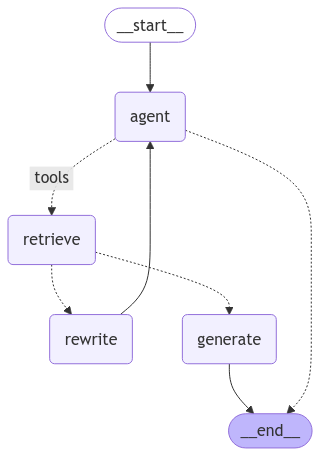

In [34]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [37]:
import pprint

inputs = {
    "messages": [
        ("user", "星展銀行推出什麼信用卡？"),
    ]
}
output = graph.invoke(inputs)
# for output in graph.stream(inputs):
#     for key, value in output.items():
#         pprint.pprint(f"Output from node '{key}':")
#         pprint.pprint("---")
#         pprint.pprint(value, indent=2, width=80, depth=None)
#     pprint.pprint("\n---\n")

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


/Users/sarah/Desktop/AI/llm_env/lib/python3.11/site-packages/langsmith/client.py:323: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [38]:
output['messages'][-1].content

'星展銀行推出的主要信用卡包括星展金卡/普卡。这些信用卡提供现金回馈，无上限的刷卡消费即时短信服务等功能。具体特色为：在成功刷取星展卡付款且未退换货的情况下，可获得现金回馈。参加活动需持有有效且无逾期未缴款记录的特定卡号。符合条件的新户首刷礼和月月刷卡优惠等活动也适用于这些信用卡。此外，附属卡提供免年费服务。持卡人还可在电商业务、代购服务、影音娱乐、电玩游戏、Coupang、Amazon等平台享受额外折扣或回扣。同时，星展PChome Prime联名卡提供了更多优惠和回馈计划。'

In [73]:

from langchain_core.runnables import RunnablePassthrough
import opencc

from opik.integrations.langchain import OpikTracer
import os
import opik
# opik.configure(use_local=True)

# Create the Opik tracer
# opik_tracer = OpikTracer(tags=["langchain", "ollama"])
# os.environ["OPIK_PROJECT_NAME"] = "credit-card-helper"
converter = opencc.OpenCC('s2t.json')


model = ChatOllama(model='qwen2:7b-instruct', temperature=0)
# .with_config({"callbacks": [opik_tracer]})

QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI question-answering assistant. Your task is to answer the question based on the similar questions. 
    The rereferred answer for the similar questions is included. Please filter and reply with an answer. 
    No pre-amble or explanation. Please output text only, not in markdown format.
    
    Documents: 
    {context}

    Question:
    {question}

    Answer:""",
)

def format_docs(docs):
    return "\n\n".join([f"DOCUMENT {index}\nTitle: {d.metadata['title']}\nReleased bank: {d.metadata['bank']}\n{d.page_content}" for index, d in enumerate(docs)])

def format_qa(docs):
    return "\n\n".join([f"Credit Card: {d.metadata['credit_card']}\nQuestion: {d.page_content}\nAnswer: {d.metadata['answer']}\n" for index, d in enumerate(docs)])

chain = (
    {"context": ensemble_retriever | format_qa, "question": RunnablePassthrough()}
    | QUERY_PROMPT
    | model
    | StrOutputParser()
)

response = chain.invoke(query)
# compression_retriever.invoke(question)
print(converter.convert(response))

星展PChome Prime聯名卡在多個通路上提供優惠，包括：

1. **PChome平臺**：享有最高達6%的回饋率。
2. **其他品牌合作**：與不同品牌合作，提供生活領域的優惠。
3. **餐飲及電影票**：享受餐飲優惠和威秀影城的電影票折扣。
4. **節日或特殊活動**：推出專屬的節日或特殊活動回饋方案。

這些優惠讓持卡人在不同的消費場景中都能獲得實惠。


In [37]:
from ollama import Client
client = Client(
  host='http://localhost:11434',
  headers={'x-some-header': 'some-value'}
)
response = client.chat(model='llama3.2', messages=[
  {
    'role': 'user',
    'content': 'Why is the sky blue?',
  },
])

In [44]:
response.message['content']

"The sky appears blue because of a phenomenon called scattering, which occurs when sunlight interacts with the tiny molecules of gases in the Earth's atmosphere.\n\nHere's a simplified explanation:\n\n1. When sunlight enters the Earth's atmosphere, it consists of a spectrum of colors, including all the colors of the visible light.\n2. The shorter (blue) wavelengths are scattered more than the longer (red) wavelengths by the tiny molecules of gases such as nitrogen and oxygen in the air.\n3. This scattering effect is known as Rayleigh scattering, named after the British physicist Lord Rayleigh, who first described it in the late 19th century.\n4. As a result of this scattering, the blue light is distributed throughout the atmosphere, giving the sky its blue appearance.\n5. The longer wavelengths (red and orange) continue to travel in a straight line, reaching our eyes from a more direct path, which is why we see them as they are coming from the sun.\n\nThis phenomenon explains why the s